In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import torch
device = torch.device('cpu')


#JAX
import jax
import jax.numpy as jnp

from jax_cosmo.scipy import interpolate as jax_interpolate

# Probably should specify in the outer script, not the inner modules
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

# for Matern kernel with Modified Bessel of the 2nd kind (tfp>=0.17.0-dev20220322)
import tensorflow_probability as tfp


#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)


%matplotlib inline
from pyke import kepcotrend,kepdetrend,kepmask
%matplotlib inline

fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style():
    global fig
    mpl.style.use('default')
    plt.rcParams.update(rcParams)
    fig.patch.set_alpha(0)

FS = 18 # fontsize


import warnings
warnings.simplefilter("ignore", UserWarning)

def to_date(time_array,offset_date='2000-01-01T00:00:00'):
    return np.array([pd.Timedelta(x,'days').round('d')+pd.Timestamp(offset_date) for x in time_array])

<Figure size 432x288 with 0 Axes>

# Download Kepler Light curves

In [2]:
!ls

CBVs                    Overview.ipynb          light_curves_CBV_corr
Data_analysis.ipynb     Power_spectra.ipynb     light_curves_CBV_corr_1
Data_analysis_old.ipynb Spectra.ipynb           light_curves_CBV_corr_2
Data_reduction.ipynb    kepcotrend.log          reduced_light_curves
MCMC_chains             light_curves


In [3]:
!cd light_curves

In [4]:
download_command = 'wget -r -np -nH -q -erobots=off -A llc.fits -P light_curves/ --cut-dirs=4 https://archive.stsci.edu/missions/kepler/lightcurves/'

In [5]:
q = np.array(os.listdir('light_curves'))
q = np.sort(q)
q

array(['.DS_Store', '002694186', '002837332', '003347632', '005781475',
       '006932990', '007175757', '007523720', '007610713', '008946433',
       '009145961', '009215110', '009650712', '010645722', '010798894',
       '010841941', '011413175', '011606854', '012010193', '012158940',
       '012208602', '012401487'], dtype='<U9')

In [27]:
'''kids_to_download = [7523720,7610713,8946433,9145961,9650712]
for kid in kids_to_download:
    os.system(download_command+'00'+str(kid)[:2]+'/00'+str(kid)+'/')'''

In [34]:
'''kids_to_download = [10645722,10798894,10841941,11413175,11606854]
for kid in kids_to_download:
    os.system(download_command+'0'+str(kid)[:3]+'/0'+str(kid)+'/')'''

In [37]:
'''kids_to_download = [12208602]
for kid in kids_to_download:
    os.system(download_command+'0'+str(kid)[:3]+'/0'+str(kid)+'/')'''

# Detrending

In [6]:
!pwd

/Users/egorssed/Desktop/Science/sbi-lensed-qso/Physics paper/datasets/Kepler


In [7]:
from astropy.io import fits
from pathlib import Path

Datafolder = './light_curves/'
CBVs_path = './CBVs/'
names = np.array(os.listdir(Datafolder))
names = names[names != '.DS_Store']
names = np.sort(names)

CBVs_names =  np.array(os.listdir(CBVs_path))
CBVs_names = CBVs_names[CBVs_names != '.DS_Store']
CBVs_names = np.sort(CBVs_names)

In [4]:
kepcotrend??

In [11]:
from copy import deepcopy
def detrend_object(object_index,listbv = '1 2',verbose=False,iterate=False,sigma=5,fitmethod='llsq',fitpower=1):
    object_path = (Datafolder)+str(names[object_index])+'/'
    for index in range(len(os.listdir(object_path))):
        detrend_curve(object_path,index,listbv,verbose,iterate,sigma,fitmethod,fitpower)

def detrend_curve(object_path,curve_index,listbv = '1 2',verbose=False,iterate=False,sigma=5,fitmethod='llsq',fitpower=1):
    curve_path = object_path+'/'+os.listdir(object_path)[curve_index]

    new_path = './light_curves_CBV_corr_'+str(len(listbv)//2 + 1)+'/'+str(names[object_index])+'/'
    Path(new_path).mkdir(parents=True,exist_ok=True)
    new_curve_path = new_path+os.listdir(object_path)[curve_index]


    with fits.open(curve_path) as hdul:
        quarter = hdul[0].header['QUARTER']

    CBV_path = CBVs_path+str(CBVs_names[quarter])
    kepcotrend(curve_path,CBV_path,listbv,outfile=new_curve_path,
               overwrite=True,verbose=verbose,iterate=iterate,sigma=sigma,fitmethod=fitmethod,fitpower=fitpower)

from astropy.io import fits

def fetch_light_curve(index,listbv = '1 2'):

    new_Datafolder = './light_curves_CBV_corr_'+str(len(listbv)//2 + 1)+'/'
    names = np.array(os.listdir(new_Datafolder))
    names = names[names != '.DS_Store']
    names = np.sort(names)

    filepath = (new_Datafolder)+str(names[index])


    dfs = []
    for i,curvename in enumerate(os.listdir(filepath)):
        path = filepath+'/'+curvename
        with fits.open(path) as hdul:

            #dataframe = pd.DataFrame(hdul[1].data)[['TIME','CADENCENO','CBVSAP_FLUX','SAP_FLUX','SAP_FLUX_ERR','SAP_BKG','SAP_BKG_ERR','PDCSAP_FLUX','PDCSAP_FLUX_ERR','SAP_QUALITY']]
            dataframe = pd.DataFrame(hdul[1].data)
            #downlinks_idx = np.where(np.isin(dataframe['SAP_QUALITY'],[98312,32768]))[0]
            binary_quality = np.vectorize(lambda x: np.binary_repr(x,width=21))(dataframe['SAP_QUALITY'])
            # bit 4 is "spacecraft is in earth point", so the thermal recovery period is expected
            downlinks_idx = np.where([(x[-4]=='1') or (x==np.binary_repr(98306,width=21)) for x in binary_quality])[0]

            thermal_recovery_mask = ~((np.arange(len(dataframe))[:,None] >= downlinks_idx[None,:]) &
                          (np.arange(len(dataframe))[:,None] <= downlinks_idx[None,:] + 150)).any(1)

            dataframe['THERMAL_RECOVERY'] = thermal_recovery_mask
            mask = np.logical_and(~np.isnan(dataframe['SAP_FLUX']).values,dataframe['SAP_QUALITY']==0).values
            #mask = (dataframe['SAP_QUALITY']==0).values
            mask = np.logical_and(mask,thermal_recovery_mask)
            dataframe['MASK'] = mask
            dataframe['FILENUM'] = np.ones(len(dataframe),dtype='int')*i
            dataframe['QUARTER'] = hdul[0].header['QUARTER']

            dfs+= [dataframe]

    dfs = np.array(dfs)[np.argsort([q['QUARTER'].min() for q in dfs])]

    """
    for index in range(1,len(dfs)):
        mask1=dfs[index]['MASK'].values
        mask2=dfs[index-1]['MASK'].values

        target = 'SAP_FLUX'
        vals1 = (dfs[index][target])[mask1]
        vals2= (dfs[index-1][target])[mask2]
        shift = np.mean(vals1[:10]) - np.mean(vals2[-10:])
        dfs[index][target] -=shift

        target = 'PDCSAP_FLUX'
        vals1 = (dfs[index][target])[mask1]
        vals2= (dfs[index-1][target])[mask2]
        shift = np.mean(vals1[:10]) - np.mean(vals2[-10:])
        dfs[index][target] -=shift


        target = 'CBVSAP_FLUX'
        vals1 = (dfs[index][target])[mask1]
        vals2= (dfs[index-1][target])[mask2]
        shift = np.mean(vals1[:10]) - np.mean(vals2[-10:])
        dfs[index][target] -=shift
    """

    #df = pd.concat(dfs)
    return dfs

# DO all the detrending in case to case basis, so we don't have chi^2=5

In [10]:
for object_index in range(len(names)):
    detrend_object(object_index,iterate=False,listbv='1',fitmethod='llsq')

Writing output file ./light_curves_CBV_corr_1/002694186/kplr002694186-2013131215648_llc.fits...
      -----      
reduced chi2: 291.7556988702192
rms: 44.19781134707141
Coefficient of CBV #1: [-0.25600395]
      -----      
Writing output file ./light_curves_CBV_corr_1/002694186/kplr002694186-2011177032512_llc.fits...
      -----      
reduced chi2: 153.7583502494513
rms: 35.66390611797244
Coefficient of CBV #1: [0.06705369]
      -----      
Writing output file ./light_curves_CBV_corr_1/002694186/kplr002694186-2012004120508_llc.fits...
      -----      
reduced chi2: 2314.995618324361
rms: 195.36544551961052
Coefficient of CBV #1: [-1.09933279]
      -----      
Writing output file ./light_curves_CBV_corr_1/002694186/kplr002694186-2012088054726_llc.fits...
      -----      
reduced chi2: 15655.624291998192
rms: 435.2959721203394
Coefficient of CBV #1: [-3.22953214]
      -----      
Writing output file ./light_curves_CBV_corr_1/002694186/kplr002694186-2012277125453_llc.fits...
      -

KeyboardInterrupt: 

In [12]:
for object_index in range(len(names)):
    detrend_object(object_index,iterate=False,listbv='1 2',fitmethod='llsq')

Writing output file ./light_curves_CBV_corr_2/002694186/kplr002694186-2013131215648_llc.fits...
      -----      
reduced chi2: 306.2822042855846
rms: 45.26906675180596
Coefficient of CBV #1: [-0.23660686]
Coefficient of CBV #2: [-0.08330189]
      -----      
Writing output file ./light_curves_CBV_corr_2/002694186/kplr002694186-2011177032512_llc.fits...
      -----      
reduced chi2: 386.5396330149902
rms: 56.60370533855868
Coefficient of CBV #1: [0.06737384]
Coefficient of CBV #2: [0.4768033]
      -----      
Writing output file ./light_curves_CBV_corr_2/002694186/kplr002694186-2012004120508_llc.fits...
      -----      
reduced chi2: 2896.7255904147296
rms: 219.06047771024885
Coefficient of CBV #1: [-1.0919598]
Coefficient of CBV #2: [-0.68868283]
      -----      
Writing output file ./light_curves_CBV_corr_2/002694186/kplr002694186-2012088054726_llc.fits...
      -----      
reduced chi2: 15678.967953273059
rms: 435.5000232965092
Coefficient of CBV #1: [-3.22975324]
Coefficient 

In [31]:
kepcotrend??

In [13]:
object_index = 0
print(names[object_index])
dfs = fetch_light_curve(object_index)

002694186


(600.0, 1600.0)

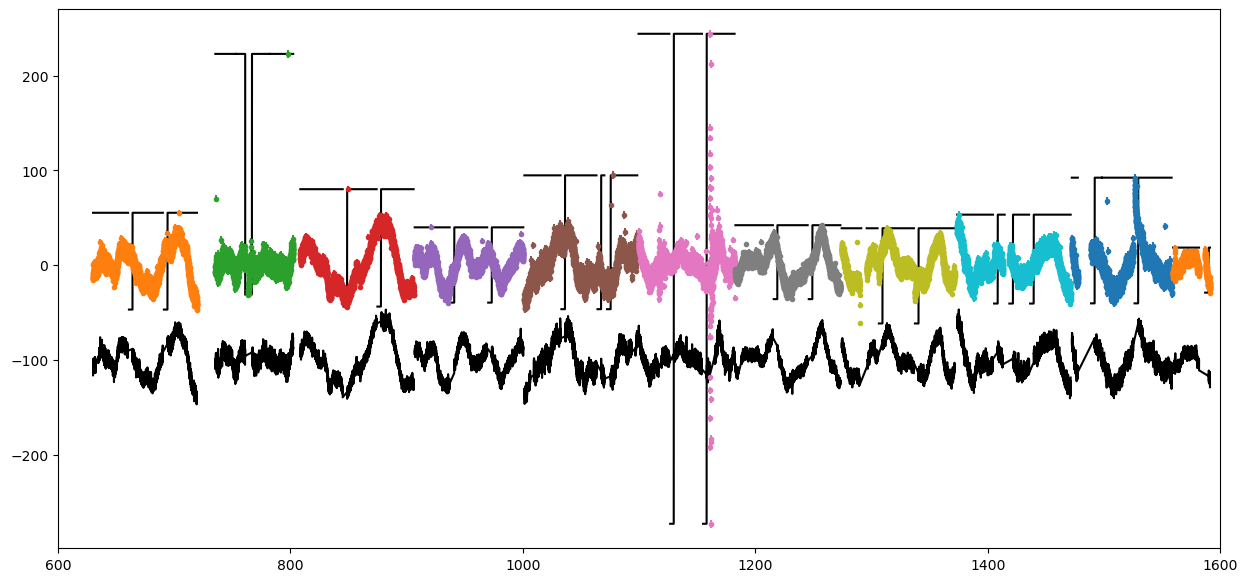

In [21]:
fig,ax = plt.subplots(figsize=(15,7))
for df in dfs:

    mask = df['MASK'].values
    vals = df['CBVSAP_FLUX'] - df['CBVSAP_FLUX'].mean()
    ax.errorbar(df['TIME'],vals,df['SAP_FLUX_ERR'],fmt='.')
    ax.plot(df['TIME'],vals.min()+df['THERMAL_RECOVERY']*(vals.max()-vals.min()),color='k')

    ax.plot(df['TIME'][mask],vals[mask]-100,color='k')
ax.set_xlim(600,1600)

002837332


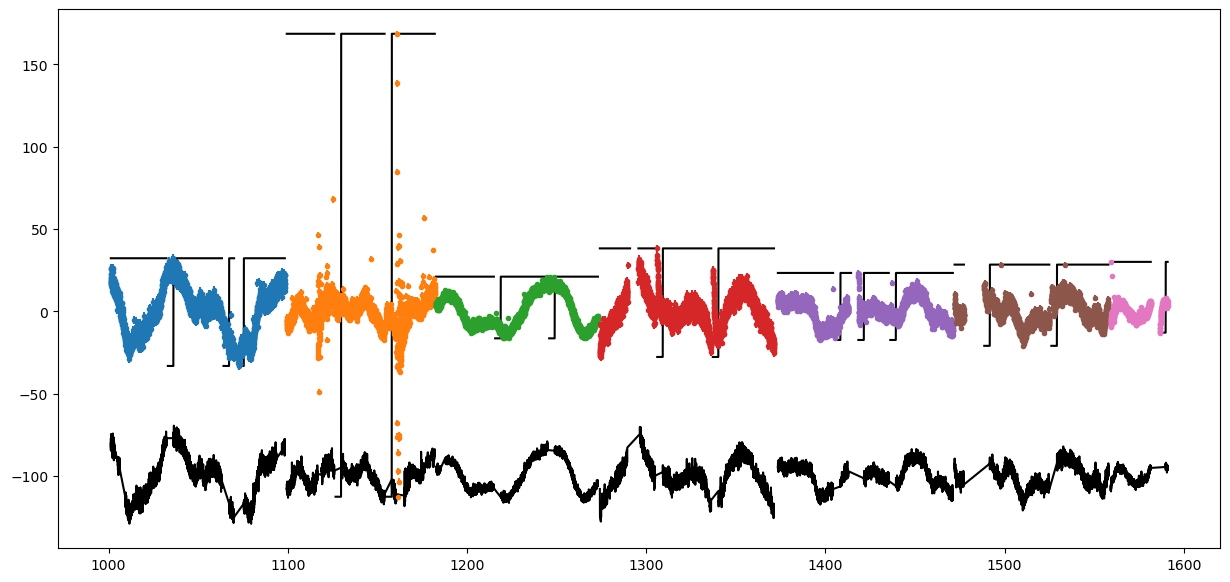

In [23]:
object_index = 1
print(names[object_index])
dfs = fetch_light_curve(object_index)

fig,ax = plt.subplots(figsize=(15,7))
for df in dfs:

    mask = df['MASK'].values
    vals = df['CBVSAP_FLUX'] - df['CBVSAP_FLUX'].mean()
    ax.errorbar(df['TIME'],vals,df['SAP_FLUX_ERR'],fmt='.')
    ax.plot(df['TIME'],vals.min()+df['THERMAL_RECOVERY']*(vals.max()-vals.min()),color='k')

    ax.plot(df['TIME'][mask],vals[mask]-100,color='k')

In [5]:
object_index = 3
print(names[object_index])
dfs = fetch_light_curve(object_index)

005781475


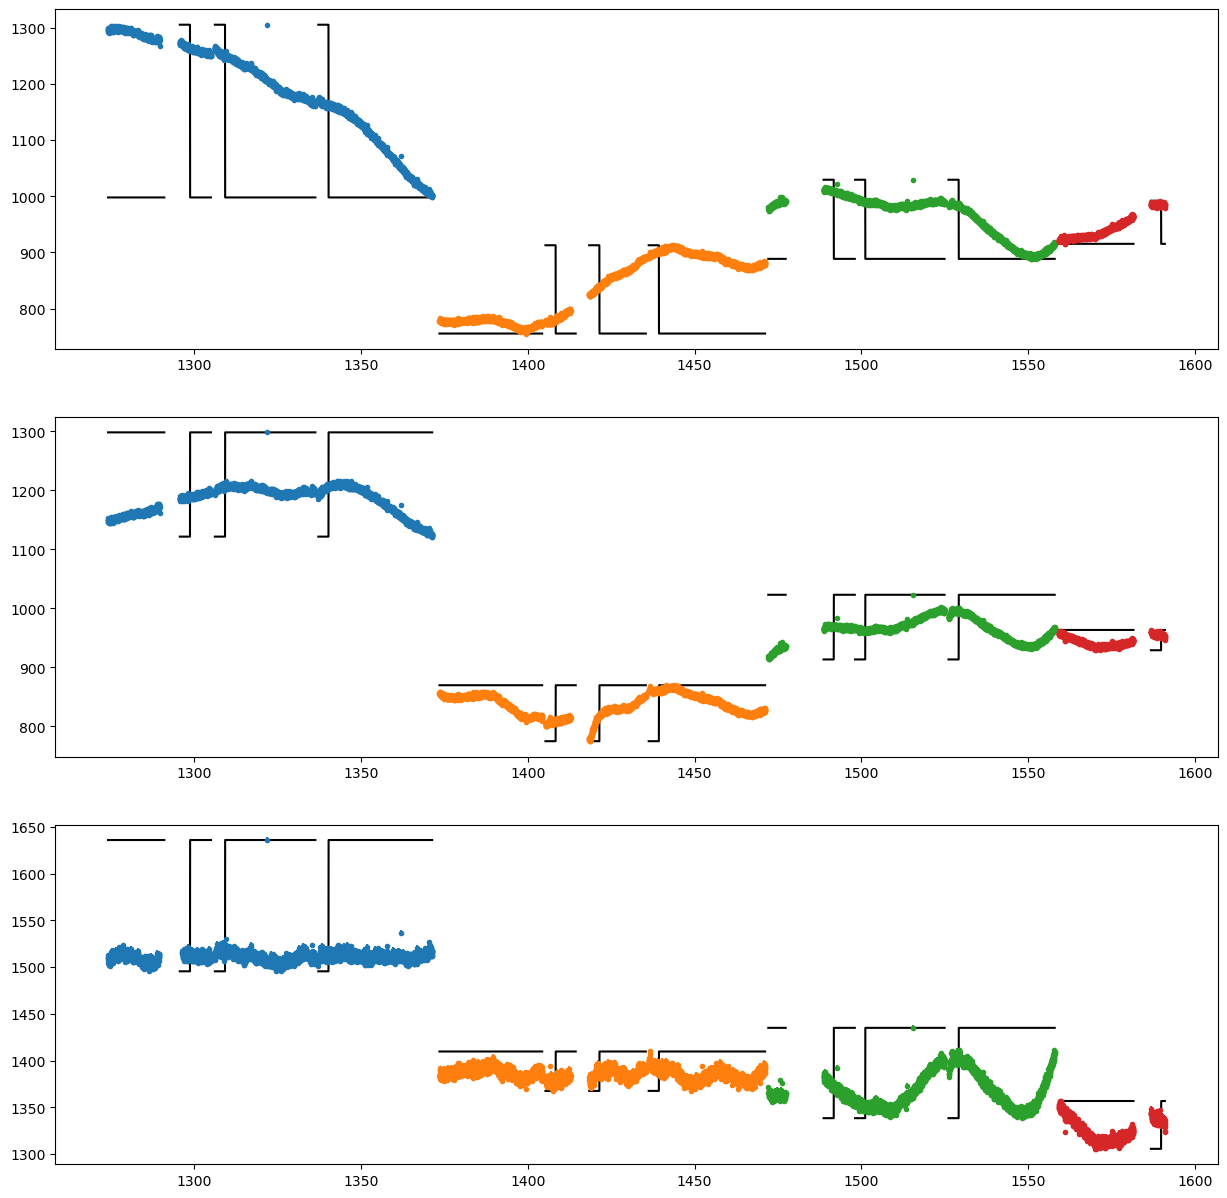

In [6]:
fig,ax = plt.subplots(3,1,figsize=(15,15))
for df in dfs:

    mask = df['MASK'].values
    ax[0].errorbar(df['TIME'],df['SAP_FLUX'],df['SAP_FLUX_ERR'],fmt='.')
    ax[0].plot(df['TIME'],df['SAP_FLUX'].min()+~df['THERMAL_RECOVERY']*(df['SAP_FLUX'].max()-df['SAP_FLUX'].min()),color='k')
    ax[1].errorbar(df['TIME'],df['CBVSAP_FLUX'],df['SAP_FLUX_ERR'],fmt='.')
    ax[1].plot(df['TIME'],df['CBVSAP_FLUX'].min()+df['THERMAL_RECOVERY']*(df['CBVSAP_FLUX'].max()-df['CBVSAP_FLUX'].min()),color='k')

    ax[2].errorbar(df['TIME'],df['PDCSAP_FLUX'],df['PDCSAP_FLUX_ERR'],fmt='.')
    ax[2].plot(df['TIME'],df['PDCSAP_FLUX'].min()+df['THERMAL_RECOVERY']*(df['PDCSAP_FLUX'].max()-df['PDCSAP_FLUX'].min()),color='k')

In [49]:
df = pd.concat(fetch_light_curve(3,listbv='1 2'))

In [50]:
df.iloc[6681:]

,TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,...,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2,CBVSAP_MODL,CBVSAP_FLUX,THERMAL_RECOVERY,MASK,FILENUM,QUARTER
1924,1412.800767,0.001013,63810,796.722595,1.665892,334.594330,0.108948,1383.785767,2.763637,0,...,406.609696,0.002868,-0.001088,0.010278,0.026618,819.509462,True,True,2,15
1925,1412.821199,0.001012,63811,NaN,NaN,NaN,NaN,NaN,NaN,32800,...,NaN,NaN,NaN,NaN,NaN,NaN,True,False,2,15
1926,1412.841632,0.001011,63812,NaN,NaN,NaN,NaN,NaN,NaN,32768,...,NaN,NaN,-929.777771,-407.634552,NaN,NaN,False,False,2,15
1927,1412.862065,0.001010,63813,NaN,NaN,NaN,NaN,NaN,NaN,32768,...,NaN,NaN,-929.777771,-407.634552,NaN,NaN,False,False,2,15
1928,1412.882497,0.001009,63814,NaN,NaN,NaN,NaN,NaN,NaN,32768,...,NaN,NaN,-929.777771,-407.634552,NaN,NaN,False,False,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1590.919902,0.000485,72527,985.707581,1.763889,368.182861,0.112325,1335.899048,2.484381,0,...,410.654771,0.002824,0.010539,-0.004506,-0.030915,956.785295,True,True,3,17
1552,1590.940337,0.000485,72528,984.884277,1.763720,368.294220,0.112478,1333.123535,2.480670,0,...,410.653354,0.002839,0.010704,-0.004693,-0.031293,955.608387,True,True,3,17
1553,1590.960771,0.000486,72529,986.081360,1.763927,367.359772,0.112393,1329.122925,2.480510,0,...,410.652725,0.002840,0.010670,-0.004530,-0.030998,957.081263,True,True,3,17
1554,1590.981206,0.000487,72530,984.956909,1.763643,367.998962,0.112371,1323.740112,2.444988,0,...,410.651299,0.002832,0.011810,-0.005066,-0.032800,954.271025,True,True,3,17


In [24]:
filepath = './reduced_light_curves/temp_1/'
Path(filepath).mkdir(parents=True,exist_ok=True)

In [25]:
!

In [53]:
filepath = './reduced_light_curves/temp_2/'
Path(filepath).mkdir(parents=True,exist_ok=True)

In [54]:
for object_index,name in enumerate(names):
    df = pd.concat(fetch_light_curve(object_index,listbv='1 2'))
    q = df[['TIME','CADENCENO','PDCSAP_FLUX','PDCSAP_FLUX_ERR','CBVSAP_FLUX','SAP_FLUX','SAP_FLUX_ERR','SAP_QUALITY','THERMAL_RECOVERY','MASK','QUARTER']]
    q.columns = ['time','cadenceno','flux','flux err','cbv flux','raw flux','raw flux err','quality','thermal recovery','mask','quarter']
    q.to_csv(filepath+str(name)+'.csv')